In [13]:
# GPU を無効化する
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from datetime import datetime
from decimal import Decimal, ROUND_HALF_UP
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


input_dir = '/home/maeda/data/geosciAI24/TC_data_GeoSciAI2024/'

(64, 64)


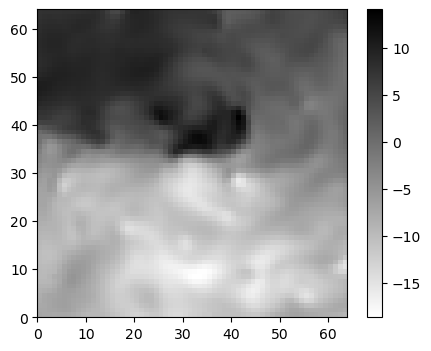

[[-7.1411133 -7.305908  -7.397461  ... -8.459473  -8.734131  -9.100342 ]
 [-7.397461  -7.2875977 -7.0861816 ... -7.7819824 -7.8552246 -8.093262 ]
 [-7.6171875 -7.470703  -7.0495605 ... -7.8918457 -7.5805664 -7.562256 ]
 ...
 [ 8.03833    8.294678   8.404541  ...  4.925537   5.1086426  5.456543 ]
 [ 7.836914   8.03833    8.111572  ...  5.3466797  5.657959   6.060791 ]
 [ 7.6171875  7.763672   7.800293  ...  5.5114746  5.8776855  6.2438965]]


In [5]:
x = np.load('/home/maeda/data/geosciAI24/TC_data_GeoSciAI2024/field_data/1979/U850/u850_1979010106_055_011s.npz')
print(x['data'].shape)

plt.figure(figsize=(5,4))
fig = plt.pcolormesh(x['data'], cmap='gray_r', )
cbar = plt.colorbar(fig)
plt.show()
print(x['data'])

In [3]:
# glob : 指定したパターンに一致するファイルパスのリストを取得
files = glob.glob(input_dir + 'track_data/197901*')
path  = []
for csvfile in files:
    df = pd.read_csv(csvfile)
    tsteps = df.shape[0] 
    print(df.iloc[0])
    print(tsteps)
    for index, row in df.iterrows():
        ymdh = datetime.strptime(row.iloc[0], "%HZ%d%b%Y").strftime('%Y%m%d%H')
        
        lon = row.iloc[1]
        lat = row.iloc[2]
        ws = row.iloc[3]
        pmin = row.iloc[4]
        time = row.iloc[5]
        stage = row.iloc[6]
        if lat<0:
            ns = "s"
        else:
            ns = "n"

        filename = f"{ymdh}_{(round(lon)):03}_{(round(abs(lat))):03}{ns}.npz"
        print(filename)
        path.append(filename)

Time [HHzDDMMMYYYY]                             12Z28JAN1979
Longitude [degree]                                   129.985
Latitude [degree]                                    -15.412
Maximum 10m wind speed [m/s]                            10.3
Central pressure [hPa]                                999.74
Elapsed time based on genesis [hour]                     -36
Life-stage label (pre-TC:0, TC:1, post-TC:2)               0
Name: 0, dtype: object
23
1979012812_130_015s.npz
1979012818_129_016s.npz
1979012900_129_016s.npz
1979012906_127_018s.npz
1979012912_126_018s.npz
1979012918_124_018s.npz
1979013000_123_019s.npz
1979013006_122_020s.npz
1979013012_122_021s.npz
1979013018_120_021s.npz
1979013100_119_022s.npz
1979013106_119_023s.npz
1979013112_119_023s.npz
1979013118_118_024s.npz
1979020100_118_024s.npz
1979020106_118_025s.npz
1979020112_118_026s.npz
1979020118_118_027s.npz
1979020200_119_028s.npz
1979020206_120_029s.npz
1979020212_121_029s.npz
1979020218_121_029s.npz
1979020300_121_030s

In [30]:
# 各変数ごとのファイルリストを取得
def get_file_list(input_dir, start_year, end_year, field, FIELD):
    path  = []
    trackfiles = []
    data = []
    
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')
    
    for csvfile in trackfiles:
        df = pd.read_csv(csvfile)
        tsteps = df.shape[0] 
        print(df.iloc[0])
        print(tsteps)
        for index, row in df.iterrows():
            ymdh = datetime.strptime(row.iloc[0], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            
            lon = row.iloc[1]
            lat = row.iloc[2]
            ws = row.iloc[3]
            pmin = row.iloc[4]
            time = row.iloc[5]
            stage = row.iloc[6]
            if lat<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            filename = f"{field}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
            print(filename)
            data_i = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD}/{filename}')
            path.append(filename)
            data.append(data_i['data'])
    return path, data

In [ ]:
def get_data(input_dir, path, start_year, end_year, FIELD):
    data = []
    for file in path:
        x = np.load(input_dir + f'field_data//{FIELD}/{file}')
        data.append(x['data'])
    return data

#### 3ステップ＊７変数

In [30]:
def get_input_ans(start_year, end_year, input_dir, n_input = 3):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'U200', 'U850', 'V200', 'V850']
    #field = ['olr']
    #FIELD = ['OLR']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input=[]
    ans =[]
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = max([index[0], 2]) #発生時に２ステップ前のデータを使いたいが、ない場合は諦める。
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index-2:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index-2:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index-2:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index-2:end_index+4+1, 3])
        tsteps = wind.shape[0] - 2 - 4
        
        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)*3), dtype=np.float32)
            for kk in range(3):
                if lat[ii+kk]<0:
                    ns = "s"
                else:
                    ns = "n"
                # 四捨五入を１０進数で正確に行う
                round_lon = Decimal(lon[ii+kk]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                round_lat = Decimal(lat[ii+kk]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                if round_lon == 360:
                    round_lon = 0
                ymdh = datetime.strptime(time[ii+kk], "%HZ%d%b%Y").strftime('%Y%m%d%H')
                # 対応するデータの読み込み
                for jj in range(len(field)):
                    #if jj == 3:   # SST は daily data なので時間を丸めて処理
                    #    ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d00')
                    filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                    xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                    x[:,:,3*jj+kk] = xi['data']
                    
                input.append(x)
                ans.append(wind[ii+n_input+4-1])
            
    return np.array(input), np.array(ans)

In [32]:
input_train, ans_train = get_input_ans(1979, 1980, input_dir)
print(input_train.shape)
print(ans_train.shape)

(14295, 64, 64, 21)
(14295,)


In [38]:
input_train = np.nan_to_num(input_train, nan=0)

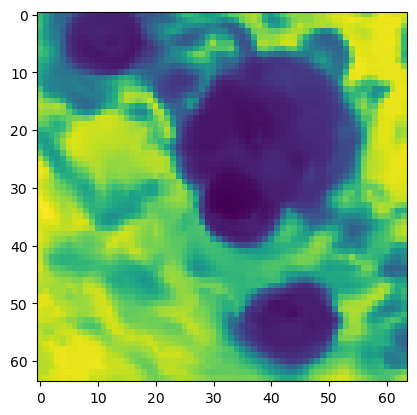

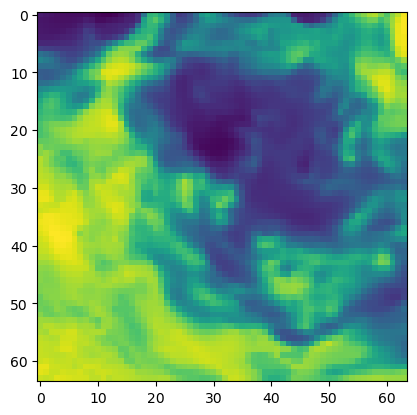

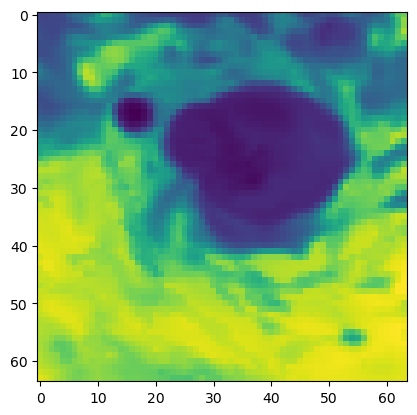

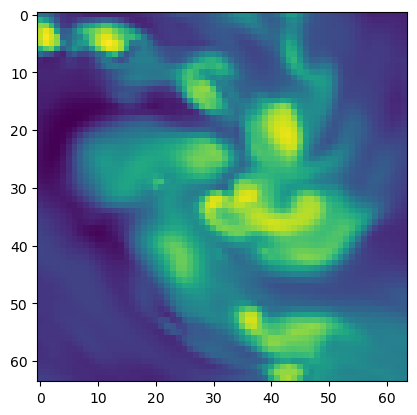

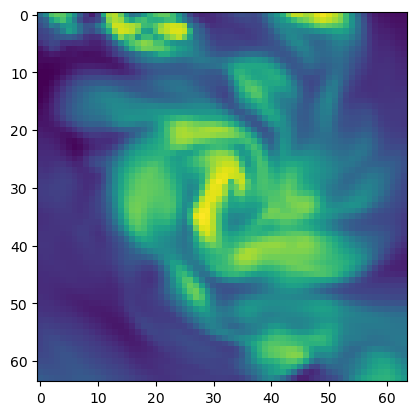

In [37]:
for i in range(5):
    plt.imshow(input_train[0,:,:,i])
    plt.show()

#### １変数

In [10]:
def get_input_ans(start_year, end_year, input_dir, n_input = 1):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'U200', 'U850', 'V200', 'V850']
    #field = ['olr']
    #FIELD = ['OLR']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input = []
    ans = []
    latlon = []
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = max([index[0], 2]) #発生時に２ステップ前のデータを使いたいが、ない場合は諦める。
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index:end_index+4+1, 3])
        tsteps = wind.shape[0] - 4
        
        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)), dtype=np.float32)
            if lat[ii]<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            # 対応するデータの読み込み
            for jj in range(len(field)):
                #if jj == 3:   # SST は daily data なので時間を丸めて処理
                #    ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d00')
                filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                x[:,:,jj] = xi['data']
                
            input.append(x)
            ans.append(wind[ii+n_input+4-1])
            
    return np.array(input), np.array(ans)

#### 過去データ

In [68]:
def get_input_ans(start_year, end_year, input_dir, n_input = 1):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'sst', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'SST', 'U200', 'U850', 'V200', 'V850']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input = []
    ans = []
    times = []
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = index[0]
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index:end_index+4+1, 3])
        tsteps = wind.shape[0] - 4
        # SST data にあわせるため、初期は 00 時刻のデータを読み込む
        if time[0][:2] == '06':
            time = time[3:]
            lon  = lon[3:]
            lat  = lat[3:]
            wind = wind[3:]
            tsteps = tsteps - 3 
        elif time[0][:2] == '12':
            time = time[2:]
            lon  = lon[2:]
            lat  = lat[2:]
            wind = wind[2:]
            tsteps = tsteps - 2
        elif time[0][:2] == '18':
            time = time[1:]
            lon  = lon[1:]
            lat  = lat[1:]
            wind = wind[1:] 
            tsteps = tsteps - 1  

        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)), dtype=np.float32)
            if lat[ii]<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            if str(ymdh[-2:]) == '00':   # SST は daily data なので00時の位置データで読み込む
                ymdh_sst = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d%H')
                lon_sst = lon[ii]
                lat_sst = lat[ii]
                if lat_sst<0:
                    ns_sst = "s"
                else:
                    ns_sst = "n"
            # 対応するデータの読み込み
            for jj in range(len(field)):
                if jj == 3:   # SST の読み込み
                    round_lon_sst = Decimal(lon_sst).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                    round_lat_sst = Decimal(lat_sst).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                    if round_lon_sst == 360:
                        round_lon_sst = 0
                    filename = f"{field[jj]}_{ymdh_sst}_{(round_lon_sst):03}_{(abs(round_lat_sst)):03}{ns_sst}.npz"
                    xi = np.load(input_dir + f'field_data/{ymdh_sst[:4]}/{FIELD[jj]}/{filename}')
                else:
                    filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                    xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                x[:,:,jj] = xi['data']
                
            input.append(x)
            ans.append(wind[ii+n_input+4-1])
            times.append(time[ii])
    return np.array(input), np.array(ans), np.array(times)


In [69]:
input_train, ans_train, time = get_input_ans(1979, 1980, input_dir)
print(input_train.shape)
print(ans_train.shape)
print(time.shape)

(4518, 64, 64, 8)
(4518,)
(4518,)


## 海水温を導入

In [30]:
def get_input_ans(start_year, end_year, input_dir, n_input = 1):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'U200', 'U850', 'V200', 'V850']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input = []
    ans   = []
    times = []
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = index[0] #発生時に２ステップ前のデータを使いたいが、ない場合は諦める。
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index:end_index+4+1, 3])
        tsteps = wind.shape[0] - 4
        
        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)), dtype=np.float32)
            if lat[ii]<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            # 対応するデータの読み込み
            for jj in range(len(field)):
                #if jj == 3:   # SST は daily data なので時間を丸めて処理
                #    ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d00')
                filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                x[:,:,jj] = xi['data']
                
            times.append(time[ii])
            input.append(x)
            ans.append(wind[ii+n_input+4-1])
            
    return np.array(input), np.array(ans), np.array(times)

In [31]:
input_train, ans_train = get_input_ans(1979, 1980, input_dir)
input_valid, ans_valid = get_input_ans(1981, 1982, input_dir)

print(input_train.shape)
print(ans_train.shape)
print(input_valid.shape)
print(ans_valid.shape)

ValueError: too many values to unpack (expected 2)

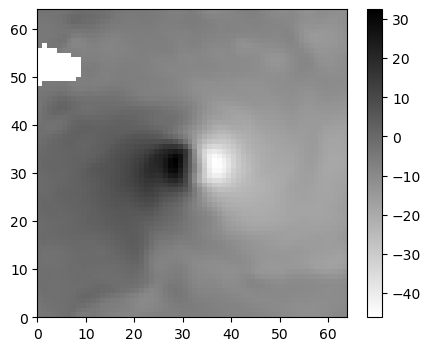

In [29]:
plt.figure(figsize=(5,4))
fig = plt.pcolormesh(input_train[232,:,:,6], cmap='gray_r', )
cbar = plt.colorbar(fig)
plt.show()

In [ ]:
# 標準化処理（欠損値はゼロとして計算）
input_std  = np.nanmean(input_train, axis=0)
input_mean = np.nanmean(input_train, axis=0)
ans_std    = np.nanmean(ans_train, axis=0)
ans_mean   = np.nanmean(ans_train, axis=0)

input_train_nm = (input_train - input_mean) / input_std
input_valid_nm = (input_valid - input_mean) / input_std
ans_train_nm   = (ans_train - ans_mean) / ans_std
ans_valid_nm   = (ans_valid - ans_mean) / ans_std

In [151]:
plt.figure(figsize=(5,4))
#for i in range(30):
#    fig = plt.pcolormesh(input_train[i,:,:,6], cmap='gray_r', )
#    cbar = plt.colorbar(fig)
#    plt.show()
print(input_mean[:,:10,6])

[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]


<Figure size 500x400 with 0 Axes>

In [98]:
# CNNモデルの構築
def cnn_model():
    model = Sequential()
    # 入力画像　25×144×3 ：(緯度方向の格子点数)×(軽度方向の格子点数)×(チャンネル数、OLRのラグ)
    model.add(Conv2D(32, (2, 2), padding='same', input_shape=(64, 64, 7), strides=(2,2)))   
    model.add(BatchNormalization())
    model.add(Activation('relu'))                                           
    model.add(Conv2D(64, (2, 2), padding='same', strides=(2,2)))                                        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (2, 2), padding='same', strides=(2,2)))                           
    model.add(BatchNormalization())
    model.add(Conv2D(256, (2, 2), padding='same', strides=(2,2)))                           
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 

    model.add(Flatten())  # 一次元の配列に変換                                # 1*16*64 -> 1024
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Dense(1, activation='linear'))
    model.summary()
    return model

In [99]:
model = cnn_model()
model.compile(optimizer=Adam(), loss='mean_squared_error')
history = model.fit(input_train, ans_train, epochs=10, batch_size=128, validation_data=(input_valid, ans_valid))

/home/maeda/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 708,065 (2.70 MB)

 Trainable params: 707,105 (2.70 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10


2024-04-27 23:29:36.263323: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546488320 exceeds 10% of free system memory.


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: nan - val_loss: nan
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: nan - val_loss: nan
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: nan - val_loss: nan
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: nan - val_loss: nan
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: nan - val_loss: nan
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: nan - val_loss: nan
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: nan - val_loss: nan
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: nan - val_loss: nan
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: nan - val_loss: nan
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: nan - val_loss: nan


# 評価データの解析


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from datetime import datetime
result_dir = '/home/maeda/machine_learning/results/geosciAI24/predict/'

ans_mean, ans_std =  30.16864997588459, 8.726771295021933
scores = []
predicts = []
box = [0, 1, 3, 4, 6, 7, 8, 12, 13, 14, 16, 19]
for j in box:
    result_file = result_dir + f"predict_test{(j):03}.npz"

    df = np.load(result_file)
    scores.append(df['score'])
    predicts.append(df['predict'][:,0])
    print(df['predict'].shape)

scores = np.array(scores)
print(scores)
predicts = np.array(predicts)
ans = df['ans']

print(scores.shape, predicts.shape, ans.shape)


(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
(9319, 1)
[0.38711807 0.39127702 0.3976571  0.3808265  0.38992062 0.38519996
 0.38409775 0.39060345 0.37491888 0.39716315 0.39154801 0.41040739]
(12,) (12, 9319) (9319,)


In [85]:
print(predicts[0, :30])
ans_rcn = ans * ans_std + ans_mean
print(ans_rcn[:30])
rmse = np.sqrt(np.mean((ans_rcn - predicts)**2, axis=1))
rmse_ensemble = np.sqrt(np.mean((ans_rcn - predicts.mean(axis=0))**2))

print(rmse, rmse_ensemble)

[32.490265 33.451473 31.156906 28.876337 34.077126 34.265057 32.404697
 31.217886 34.034397 35.842415 32.893394 34.607605 37.550056 32.836
 34.81754  32.23725  32.455063 34.62066  30.850914 26.71821  26.041557
 25.113182 26.323982 24.565859 24.737904 25.555504 24.057629 27.205112
 23.819153 22.219893]
[31.87806672 29.02930226 30.45368449 31.30831383 31.7831079  34.82178999
 33.77724302 37.00584274 37.57559563 36.7209663  36.34113104 36.62600748
 37.00584274 36.43608985 35.20162525 32.92261369 31.02343738 29.97889041
 30.07384923 27.79483766 31.87806672 29.31417871 29.69401397 32.35286079
 28.26963174 23.42673216 25.04103202 28.649467   21.90739112 20.48300889]
[5.46459475 5.56508931 5.52876057 5.40218048 5.4801279  5.46843344
 5.43282838 5.44610479 5.33427453 5.48867075 5.41375662 5.71348789] 5.140160732683784


In [83]:
ensemble = predicts.mean(axis=0)

Text(0, 0.5, 'Predicted')

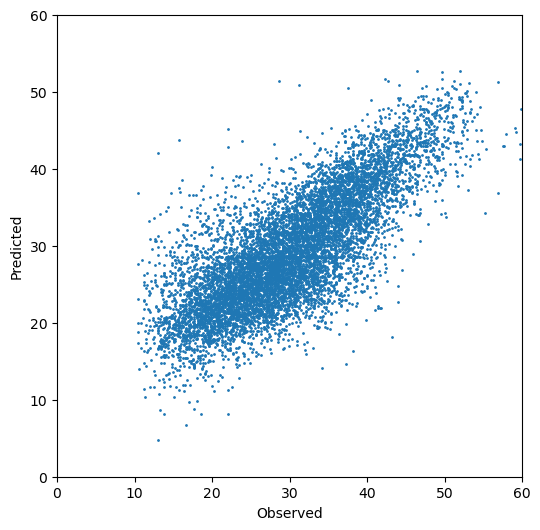

In [56]:
plt.figure(figsize=(6, 6))
plt.scatter(ans_rcn, predicts[0], s=1)
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xlabel('Observed')
plt.ylabel('Predicted')

(array([  4.,   4.,   3.,   9.,  19.,  32.,  48.,  89., 132., 159., 251.,
        340., 356., 413., 416., 430., 460., 435., 445., 479., 439., 402.,
        369., 342., 327., 320., 284., 283., 234., 236., 234., 205., 178.,
        142., 137., 141., 102.,  71.,  88.,  58.,  59.,  37.,  35.,  23.,
         21.,   8.,   9.,   6.,   2.,   3.]),
 array([-2.35649157, -2.24960732, -2.14272332, -2.03583908, -1.92895508,
        -1.82207096, -1.71518683, -1.60830271, -1.50141859, -1.39453447,
        -1.28765035, -1.18076622, -1.0738821 , -0.96699792, -0.8601138 ,
        -0.75322968, -0.64634556, -0.53946143, -0.43257728, -0.32569316,
        -0.21880904, -0.11192491, -0.00504078,  0.10184335,  0.20872748,
         0.3156116 ,  0.42249572,  0.52937984,  0.63626397,  0.74314809,
         0.85003221,  0.95691633,  1.06380045,  1.17068458,  1.2775687 ,
         1.38445282,  1.49133694,  1.59822106,  1.7051053 ,  1.81198943,
         1.91887355,  2.02575755,  2.13264179,  2.23952579,  2.34641004,
 

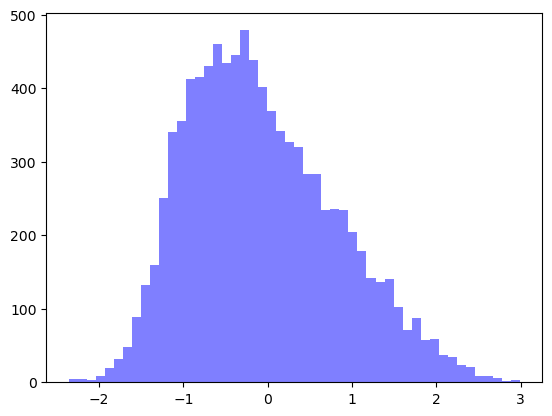

In [62]:
plt.hist((predicts[4] - ans_mean) / ans_std, bins=50, alpha=0.5, color='blue', label='Predicted')

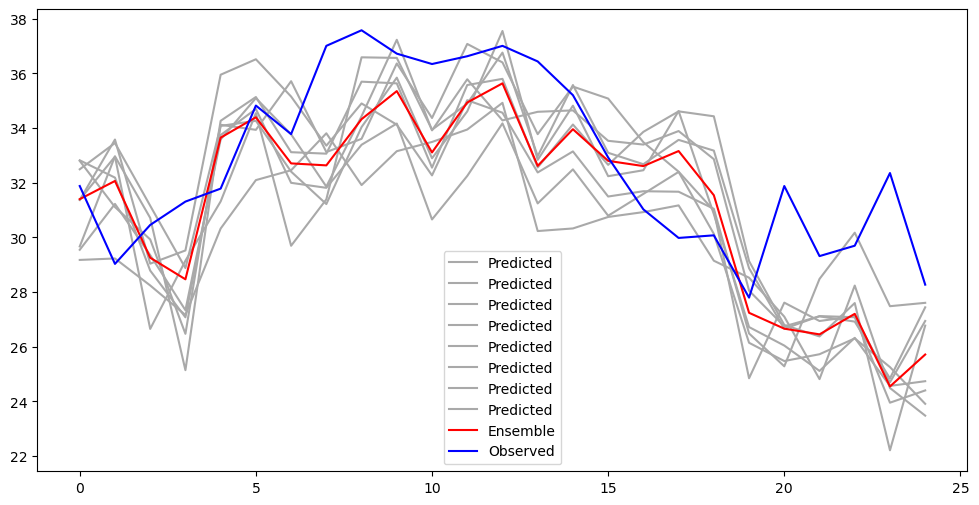

In [84]:
# 時系列データの事例
plt.figure(figsize=(12, 6))

for i in range(8):
    plt.plot(predicts[i,:25], label='Predicted', color='darkgrey')
plt.plot(ensemble[:25], label='Ensemble', color='red')
plt.plot(ans_rcn[:25], label='Observed', color='blue')
plt.legend()

# Pytorchで記述する


In [26]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

In [41]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(7, 32, kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*8*8, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x
model = CNNModel()

summary(model, input_size=(7, 64, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             928
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]           8,256
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9            [-1, 128, 8, 8]          32,896
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
          Dropout-12            [-1, 128, 8, 8]               0
           Linear-13                  [-1, 128]       1,048,704
             ReLU-14                  [

In [ ]:
input_train, ans_train = get_input_ans(1979, 1980, input_dir)
input_valid, ans_valid = get_input_ans(1981, 1982, input_dir)

print(input_train.shape)
print(ans_train.shape)
print(input_valid.shape)
print(ans_valid.shape)

In [42]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
for seed in range(17, 30):
    print('Seed =', seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # モデルの初期化
    model = CNNModel()
    print(model)
    # データローダーの作成とモデルの訓練
    train_dataset = TensorDataset(torch.Tensor(input_train.transpose(0,3,1,2)), torch.Tensor(ans_train))
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_dataset = TensorDataset(torch.Tensor(input_valid.transpose(0,3,1,2)), torch.Tensor(ans_valid))
    valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
    print(train_dataset[0][0].shape)  # 入力データの形状
    print(train_dataset[0][1].shape)  # 正解データの形状
    best_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(30):
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_dataset)
        
        model.eval()
        valid_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in valid_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item() * inputs.size(0)
        
        valid_loss /= len(valid_dataset)
        
        print(f"Epoch {epoch+1}/{30} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 3:
                break


Seed = 17
CNNModel(
  (conv1): Conv2d(7, 32, kernel_size=(2, 2), stride=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
torch.Size([7, 64, 64])
torch.Size([])
Epoch 1/30 - Train Loss: nan - Valid Loss: nan
Epoch 2/30 - Train Loss: nan - Valid Loss: nan
Epoch 3/30 - Train Lo